# 97% accuracy on MNIST with a single decision tree (+ t-SNE)

In this kernel we explore the power of dimensionality reduction for high-dimensional data such as MNIST. We will reduce all 784 pixel features to 2 features and compare the impact it has on the accuracy score. For dimensionality reduction we first use [Truncated Singular Value Decomposition (TSVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition), which is a powerful compression algorithm for matrices such as MNIST digit images. After that we use [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) on the compressed data from TSVD. Luckily we can easily implement these algorithms thanks to libraries such as [scikit-learn](https://scikit-learn.org/stable/). Let's dive in!

Image: an example of t-SNE results on the MNIST dataset with labels. In this kernel we will create our own t-SNE visualization. [[Source](https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/)]

![](http://nlml.github.io/images/tsne/tsne-mnist.png)

## Table of Contents

- [Dependencies](#1)
- [Preparation](#2)
- [Metric](#3)
- [Exploratory Data Analysis (EDA)](#4)
- [Baseline model](#5)
- [Dimensionality Reduction (TSVD and t-SNE)](#6)
- [Modeling](#7)
- [Evaluation](#8)
- [Submission](#9)

## Dependencies <a id="1"></a>

Besides the usual packages we use the library [pydotplus](https://pydotplus.readthedocs.io/). This library provides a Python interface for GraphViz's Dot language and always us to visualize decision trees. Very cool!

In [1]:
# Get the pydotplus package for visualizing decision trees
!pip install pydotplus

     |████████████████████████████████| 286kB 3.5MB/s 
  Created wheel for pydotplus: filename=pydotplus-2.0.2-cp36-none-any.whl size=24566 sha256=2d619972e3ca069af8e2e4ea39a275f634caac5e8d5b056531ae9d7ccc7632ed
  Stored in directory: /tmp/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [2]:
# Standard Libraries
import os
import numpy as np 
import pandas as pd 
import random as rn

# Visualization libraries
import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({"axes.facecolor": ".95"})

# Modeling and Machine Learning
from IPython.display import Image 
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Specify Paths for easy dataloading
BASE_PATH = '../input/'
TRAIN_PATH = BASE_PATH + 'train.csv'
TEST_PATH = BASE_PATH + 'test.csv'

# Seed for reproducability
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(BASE_PATH):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(BASE_PATH + file) / 1000000, 2))))


# Files and file sizes
test.csv                      | 51.12 MB
train.csv                     | 76.78 MB
sample_submission.csv         | 0.24 MB


## Preparation <a id="2"></a>

Loading in files. Note that we concatenate the training and testing data because we would like to train our dimensionality reduction algorithms on all the data we have.

In [4]:
# Load in training and testing data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
concat_df = pd.concat([train_df, test_df])
sample_sub = pd.read_csv(BASE_PATH + 'sample_submission.csv');

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


## Metric <a id="3"></a>

The general metric for MNIST is a simple accuracy score. We use [sklearn's accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) straight out of the box for measuring performance. To get the percentage score we multiply by 100 and for readability we round the number to 2 decimals.

In [5]:
def acc(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """
        Calculates the accuracy score between labels and predictions.
        
        :param y_true: The true labels of the data
        :param y_pred: The predictions for the data
        
        :return: a floating point number denoting the accuracy
    """
    return round(accuracy_score(y_true, y_pred) * 100, 2)

## Exploratory Data Analysis (EDA) <a id="4"></a>

The data consists of a tabular format where every pixel is a feature. A single decision tree is naturally unequipped to handle that many features. That is why we use t-SNE to reduce all 784 features to 2 t-SNE features.

In [6]:
# Check out a few rows in the training data
print('Training data: ')
train_df.head(4)

Training data: 


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The visualization below shows that the target distribution is quite evenly distributed. This is convenient becaused now we don't have to perform [additional preprocessing](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18).

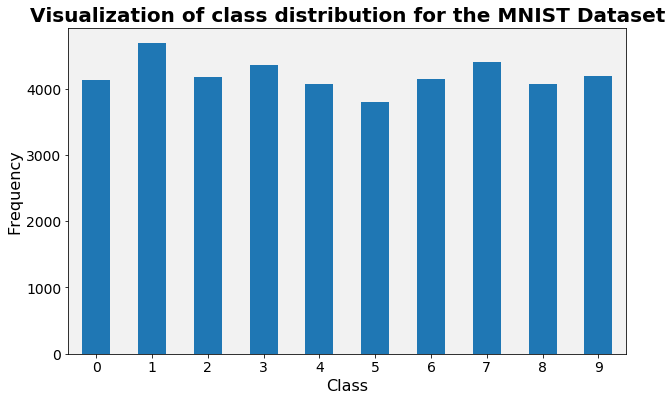

In [7]:
# Visualize target distribution
train_df['label'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Visualization of class distribution for the MNIST Dataset', fontsize=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Class', fontsize=16)
plt.ylabel('Frequency', fontsize=16);

## Baseline Model <a id="5"></a>

As a reference we train a single decision tree on all the pixel features and check what score we get. Later we train a decision tree with exactly the same hyperparameters on the t-SNE features. This allows us to compare how big the jump in accuracy is.

In [8]:
# Get all pixel features
features = [col for col in train_df.columns if col.startswith('pixel')]
# Split up training to for validation
X_train, X_val, y_train, y_val = train_test_split(train_df[features], 
                                                  train_df['label'], 
                                                  test_size=0.25, 
                                                  random_state=seed)

In [9]:
# Train baseline decision tree model
clf = DecisionTreeClassifier(max_depth=10, random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [10]:
# Evaluate the baseline model
train_preds_baseline = clf.predict(X_train)
val_preds_baseline = clf.predict(X_val)
acc_baseline_train = acc(train_preds_baseline, y_train)
acc_baseline_val = acc(val_preds_baseline, y_val)
print(f'Training accuracy for our baseline (using all pixel features): {acc_baseline_train}%')
print(f'Validation accuracy for our baseline (using all pixel features): {acc_baseline_val}%')

Training accuracy for our baseline (using all pixel features): 90.86%
Validation accuracy for our baseline (using all pixel features): 84.58%


We will write the top level of the decision tree to a .png file using [sklearn's export_graphviz function](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) and [pydotplus](https://pydotplus.readthedocs.io/). Check out the output of this kernel to see the visualized decision tree.

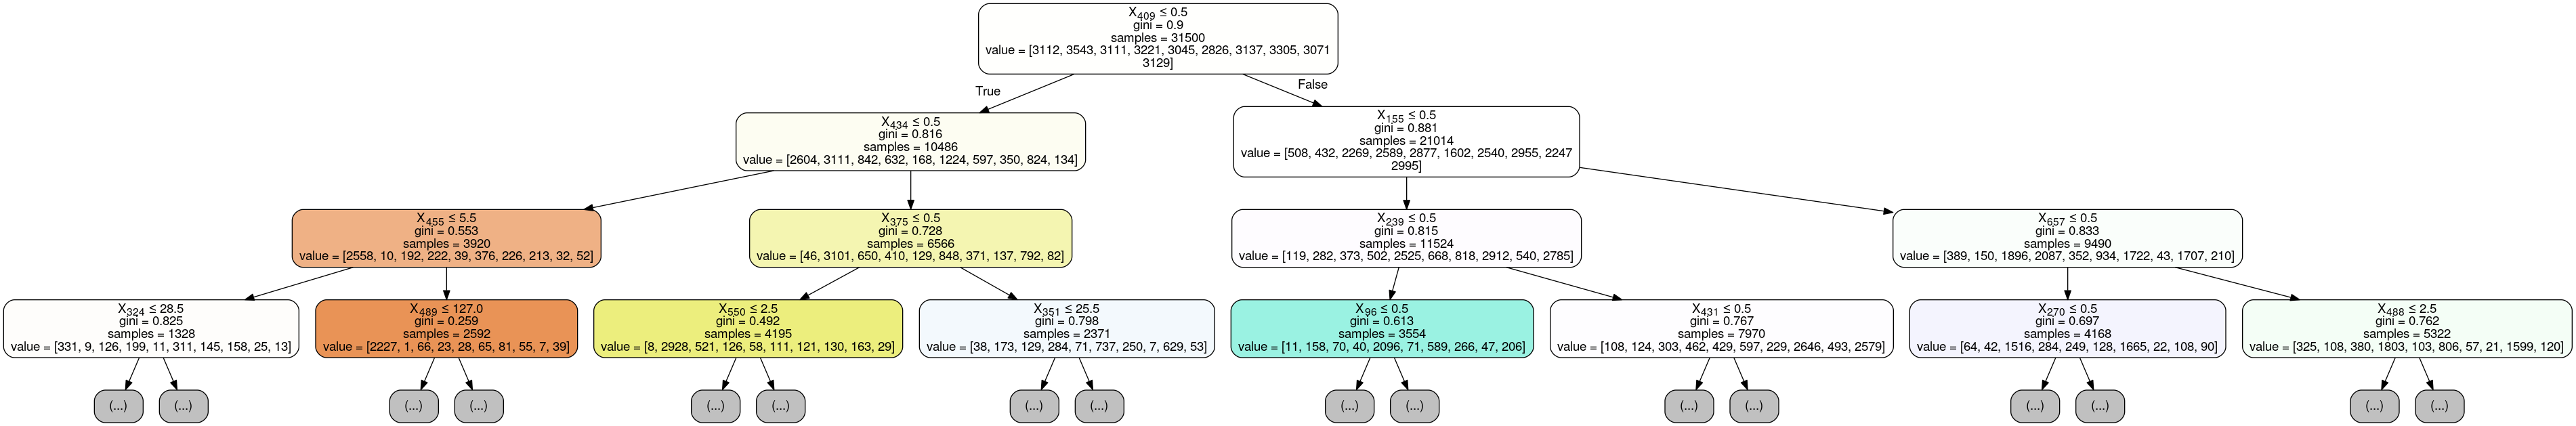

In [11]:
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# Create PNG file
Image(graph.create_png())

In [12]:
# Save PNG file
graph.write_png("mnist_decision_tree_baseline.png");

## Dimensionality Reduction (TSVD and t-SNE) <a id="6"></a>

As mentioned at the beginning of this kernel we first compress the data using Truncated Singular Value Decomposition (TSVD). The reason we don't perform t-SNE on the full dataset is because of computation and stability. TSVD is ideal for if you want to compress [sparse data](https://en.wikipedia.org/wiki/Sparse_matrix). If you are dealing with dense data then [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is often a better dimensionality reduction technique.

In [13]:
# Perform Truncated Singular Value Decomposition (TSVD) on all features
# This will reduce the amount of features to 50 and will simplify t-SNE
tsvd = TruncatedSVD(n_components=50).fit_transform(concat_df[features])

Let's see what score we get with only the TSVD reduction to 50 components.

In [14]:
# Split up the t-SNE results in training and testing data
tsvd_cols = [f'component_{i+1}' for i in range(50)]
tsvd_train = pd.DataFrame(tsvd[:len(train_df)], columns=[tsvd_cols])
tsvd_test = pd.DataFrame(tsvd[len(train_df):], columns=[tsvd_cols])

In [15]:
# Perform another split for t-sne feature validation
X_train, X_val, y_train, y_val = train_test_split(tsvd_train, 
                                                  train_df['label'], 
                                                  test_size=0.25, 
                                                  random_state=seed)

In [16]:
# Train model with t-svd features
clf = DecisionTreeClassifier(max_depth=10, random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [17]:
# Evaluate model with the 50 TSVD features and compare to the baseline model
train_preds = clf.predict(X_train)
val_preds = clf.predict(X_val)
acc_tsvd_train = acc(train_preds, y_train)
acc_tsvd_val = acc(val_preds, y_val)
print(f'Training accuracy with TSVD features (50 components): {acc_tsvd_train}%')
print(f'Validation accuracy with TSVD features (50 components): {acc_tsvd_val}%')
# Check out how it performed compared to the baseline
acc_diff = round(acc_tsvd_val - acc_baseline_val, 2)
print(f'\nThis is a difference of {acc_diff}% in validation accuracy compared to the baseline.')

Training accuracy with TSVD features (50 components): 85.1%
Validation accuracy with TSVD features (50 components): 79.41%

This is a difference of -5.17% in validation accuracy compared to the baseline.


We can see that by applying TSVD we lose information and the same decision tree classifier leads to a worse performance. However, we will see later that after applying t-SNE and using those features the same deicision tree classifier will lead to remarkable results.

After compressing the 784 pixel features to 50 features we train the t-SNE algorithm. Note that we can train the algorithm on the train and testing data combined. We don't need the target because of t-SNE's [unsupervised nature](https://en.wikipedia.org/wiki/Unsupervised_learning).

In [18]:
# Fit t-SNE on the Truncated SVD reduced data (50 features)
tsne = TSNE()
transformed = tsne.fit_transform(tsvd)  

In [19]:
# Split up the t-SNE results in training and testing data
tsne_train = pd.DataFrame(transformed[:len(train_df)], columns=['component1', 'component2'])
tsne_test = pd.DataFrame(transformed[len(train_df):], columns=['component1', 'component2'])

Besides compressing data and making simple algorithms more effective on high-dimensional data, t-SNE can also be used to create intuitive and beautiful visualizations of data. As you can see in the graph below the classes are clearly distinct from each other when compressed into a 2-dimensional space. Also, images that are similar like 3 and 9 are closer to each other than 0 and 7. In the MNIST dataset, some 7's look pretty much like a 1 and this is reflected in the t-SNE visualization.

A downside of creating a classifiers using compressed data can be that a model like a decision tree becomes less interpretable. We don't know which specific feature influences the result because all features are made up of a combination of features. We can counter this by compressing groups of features that have a similar meaning and have a high correlation with each other.

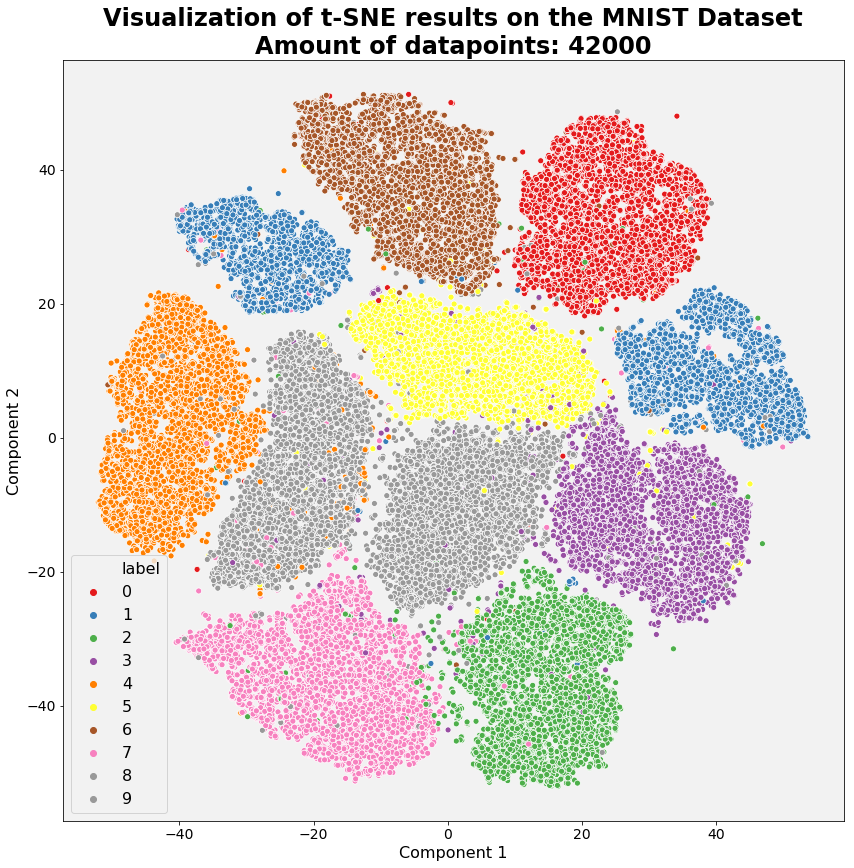

In [20]:
# Visualize the results for t-SNE on MNIST
plt.figure(figsize=(14, 14))
plt.title(f"Visualization of t-SNE results on the MNIST Dataset\n\
Amount of datapoints: {len(tsne_train)}", fontsize=24, weight='bold')
sns.scatterplot("component1", "component2", 
                data=tsne_train, hue=train_df['label'], 
                palette="Set1", legend="full")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16);

## Modeling <a id="7"></a>

Now that the t-SNE features are created we train a new [decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with the same hyperparameters.

In [21]:
# Perform another split for t-sne feature validation
X_train, X_val, y_train, y_val = train_test_split(tsne_train, 
                                                  train_df['label'], 
                                                  test_size=0.25, 
                                                  random_state=seed)

In [22]:
# Train model with t-sne features
clf = DecisionTreeClassifier(max_depth=10, random_state=seed)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

We again save the top level of the t-SNE decision tree to a .png file. This graph can look unintuitive due to the t-SNE features, but it is still interesting to examine this tree to see if appropriate splits were made. Check out the output of this kernel for decision tree visualizations.

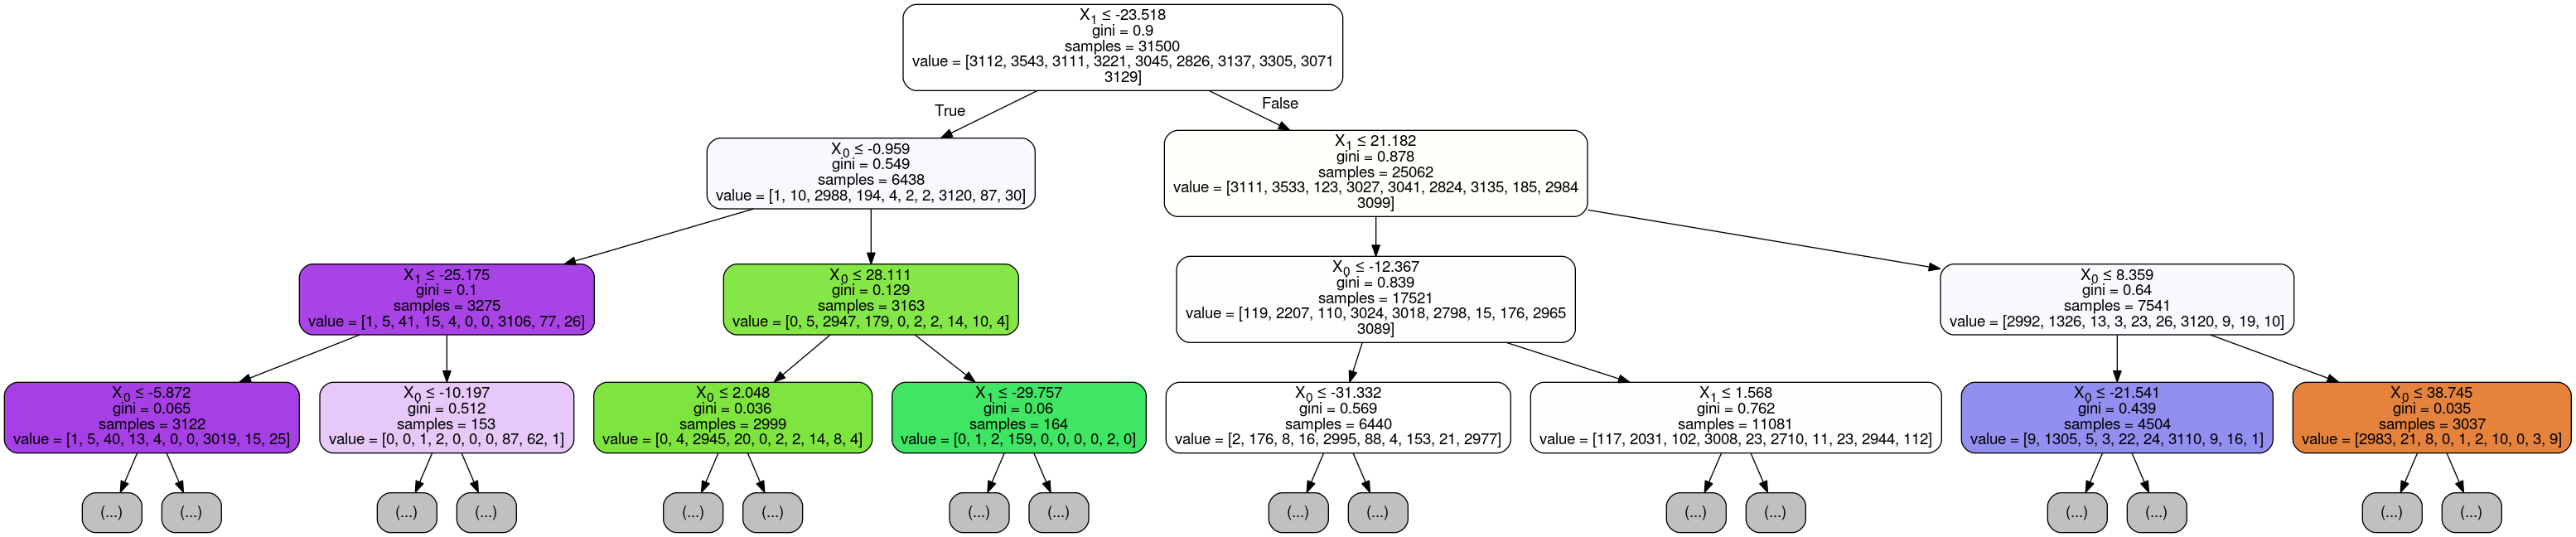

In [23]:
# Convert Decision Tree to visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# Create PNG file
Image(graph.create_png())

In [24]:
# Save the decision tree slice as PNG
graph.write_png("mnist_decision_tree_tsne.png");

## Evaluation <a id="8"></a>

We can easily see that the new decision tree with the t-SNE features is less prone to overfitting and results in a substantially higher accuracy score using the same hyperparameters!

In [25]:
# Evaluate model with t-SNE features and compare to the baseline model
train_preds = clf.predict(X_train)
val_preds = clf.predict(X_val)
acc_tsne_train = acc(train_preds, y_train)
acc_tsne_val = acc(val_preds, y_val)
print(f'Training accuracy with t-SNE features: {acc_tsne_train}%')
print(f'Validation accuracy with t-SNE features: {acc_tsne_val}%')
# Compare t-SNE results with the baseline model
acc_diff = round(acc_tsne_val - acc_baseline_val, 2)
print(f'\nThis is an improvement of {acc_diff}% in validation accuracy over the baseline!')

Training accuracy with t-SNE features: 98.17%
Validation accuracy with t-SNE features: 97.02%

This is an improvement of 12.44% in validation accuracy over the baseline!


## Submission <a id="9"></a>

Make final predictions using our decision tree classifier with t-SNE features and make a submission for Kaggle to measure our own validation against the public leaderboard.

In [26]:
# Make predictions and save submission file
predictions = clf.predict(tsne_test)
sample_sub['Label'] = predictions
sample_sub.to_csv('submission.csv', index=False)

Final check to see if the submission data is in the right format.

In [27]:
print('Submission data:')
sample_sub.head(3)

Submission data:


,ImageId,Label
0,1,2
1,2,0
2,3,9


To check if our predictions make sense we check the target distribution of the training data with the distribution of our predictions. As you can see the prediction distribution is similar to training distribution we saw at the beginning of this kernel.

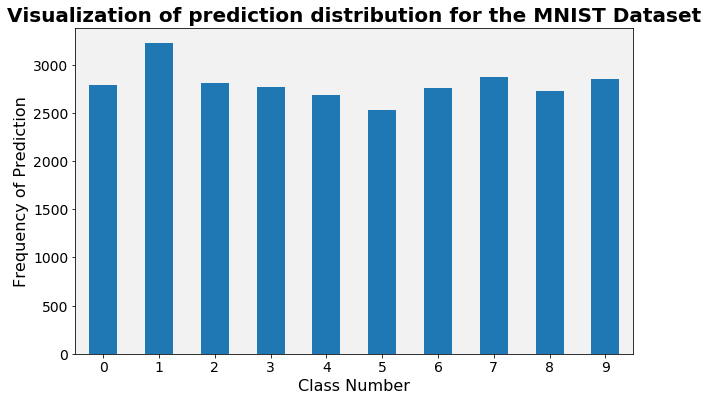

In [28]:
# Visualize prediction distribution
sample_sub['Label'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Visualization of prediction distribution for the MNIST Dataset", fontsize=20, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Class Number", fontsize=16)
plt.ylabel("Frequency of Prediction", fontsize=16);

That's it! Check out [the original paper on t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) by [Laurens van der Maaten](https://lvdmaaten.github.io/) and [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton) if you want to dive deeper into the algorithm.

Also, check out [this video from the Coursera course "How to win a data science competition"](https://www.coursera.org/lecture/competitive-data-science/t-sne-uZmLz) for more information on t-SNE.

If you like this Kaggle kernel, feel free to give an upvote and leave a comment! I will try to implement your suggestions in this kernel!